# TITLE HERE
 - Capstone Project
 - Student- Sabina Bains
 - Presentation Date- 10/05/2022
 - Instructor- Abhineet Kulkarni

# --------------------------------------- BUSINESS UNDERSTANDING ---------------------------------------------------

A picture is said to be worth a thousand words, but does that saying apply to album art? Before streaming services such as Spotify became the preferred format for music consumption,
listeners would peruse the aisles of music stores, scanning the album artwork of CD's and Vinyl Records. During this time, album art likely affected what users chose to purchase. Our goal is to predict whether album art still plays a role in the success of the album's music, and if so, which album covers are predicted to be most sucessful?


active vs passive listening. 
album art tells a story and gives context

To do this we will experiment with Convolutional Neural Networks, a class of Neural Networks that deals with handling Image data.



# ------------------------------------------ DATA UNDERSTANDING ------------------------------------------------------

In [1]:
# !pip3 install spotipy --upgrade
# !pip3 install pillow

#### Importing Packages

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib import image as mpimg
 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import re
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

# changing colors of output
COLOR = 'white'
mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import pandas as pd

# load and show an image with Pillow
from PIL import Image


from matplotlib import pyplot

import requests

from IPython.display import Image as img_display

import collections

#### Using credentials to pull album art and popularity score (target variable) from Spotify's API (SpotiPy)

In [3]:
# User will have to create their own spotipy account and put their own CID and SECRET keys into the following variables
creds  = pd.read_csv('data/spotipy_credentials.csv', header = None)

cid    = creds[1][0]
secret = creds[1][1]

In [4]:
# Accessing API
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [5]:
# Creating list of playlists with independent artists to pull album art data from
fresh_finds_playlists = [
'https://open.spotify.com/playlist/37i9dQZF1DWT0upuUFtT7o',
'https://open.spotify.com/playlist/37i9dQZF1DWUFAJPVM3HTX',
'https://open.spotify.com/playlist/37i9dQZF1DX3u9TSHqpdJC',
'https://open.spotify.com/playlist/37i9dQZF1DWW4igXXl2Qkp',
'https://open.spotify.com/playlist/37i9dQZF1DX78toxP7mOaJ',
'https://open.spotify.com/playlist/37i9dQZF1DXdS3lvGe1GrT',
'https://open.spotify.com/playlist/37i9dQZF1DWYUfsq4hxHWP',
'https://open.spotify.com/playlist/37i9dQZF1DX6bBjHfdRnza',
'https://open.spotify.com/playlist/37i9dQZF1DX8C585qnMYHP',
'https://open.spotify.com/playlist/37i9dQZF1DXcWL5K0oNHcG',
'https://open.spotify.com/playlist/37i9dQZF1DWWjGdmeTyeJ6'
]

In [6]:
# looping through playlist lists to pull all tracks from each list
playlist_uris = []

for playlist in fresh_finds_playlists:
    playlist_uris.append(playlist.split("/")[-1].split("?")[0])

In [7]:
playlist_uri_to_name_dict = {}

for playlist_uri in playlist_uris:
    playlist_name = sp.user_playlist(user=None, playlist_id=playlist_uri, fields="name")['name']
    
    if playlist_name != "Fresh Finds":
        playlist_name = playlist_name.split(' ')[-1]
    else:
        playlist_name = 'All Genres'
        
    playlist_uri_to_name_dict[playlist_uri] = playlist_name

In [368]:
playlist_uri_to_name_dict

{'37i9dQZF1DWT0upuUFtT7o': 'Indie',
 '37i9dQZF1DWUFAJPVM3HTX': 'R&B',
 '37i9dQZF1DX3u9TSHqpdJC': 'Pop',
 '37i9dQZF1DWW4igXXl2Qkp': 'Hip-Hop',
 '37i9dQZF1DX78toxP7mOaJ': 'Rock',
 '37i9dQZF1DXdS3lvGe1GrT': 'Folk',
 '37i9dQZF1DWYUfsq4hxHWP': 'Country',
 '37i9dQZF1DX6bBjHfdRnza': 'Dance',
 '37i9dQZF1DX8C585qnMYHP': 'Experimental',
 '37i9dQZF1DXcWL5K0oNHcG': 'Jazz',
 '37i9dQZF1DWWjGdmeTyeJ6': 'All Genres'}

In [8]:
# Creating dict to append to
data={}
data['track_name'] = []
data['popularity'] = []
data['album_url'] = []
data['playlist_uri'] = []


# looping through each playlist
for playlist in playlist_uris:
    
    # looping through each track in playlist to append name, popularity rating (our target variable), and album url to pull artwork.
    for track in sp.playlist_tracks(playlist)["items"]:
        # track name
        data['track_name'].append(track["track"]["name"])
        # popularity of the track
        data['popularity'].append(track["track"]["popularity"])
        # Cover Art URL
        data['album_url'].append(track["track"]['album']['images'][0]['url'])
        # playlist URI for matching later
        data['playlist_uri'].append(playlist)

In [372]:
data['album_url'][0]

'https://i.scdn.co/image/ab67616d0000b273420e1e20bcaf6fdab9ddefa4'

In [9]:
# creating dataframe from above dictionary
df = pd.DataFrame(data)

In [10]:
# adding in playlist genre
df['playlist_name'] = df.playlist_uri.replace(playlist_uri_to_name_dict)

In [11]:
len(df)

910

In [12]:
# dropping any potential duplicates 
df = df.drop_duplicates().reset_index(drop = True)

In [13]:
# cleaning track names of characters for cleaner import and export
df['track_name_cleaned'] = df.track_name.str.replace("(?i)[^0-9a-z!?.;,@' -]",'')
df['track_name_cleaned'] = df.track_name_cleaned.str.replace('.','')
df['track_name_cleaned'] = df.track_name_cleaned.str.replace('*','')
df['track_name_cleaned'] = df.track_name_cleaned.str.strip()

In [14]:
df['key'] = df['track_name_cleaned']+"_"+df['playlist_name']

In [15]:
# sorting data by trackname to match album art with popularity score
df = df.sort_values(by='key').reset_index(drop=True)

In [16]:
# # Going through each URL, downloading the image, and saving it to album_art folder
# error_list = []
# for key, url in zip(df['key'], df['album_url']):
    
#     try:
#         img_data = requests.get(url).content
#         with open(f'data/album_art/{key}.jpg', 'wb') as handler:
#             handler.write(img_data)
#     except:
#         error_list.append(key)

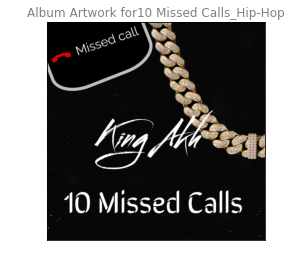

In [17]:
# Displaying example of photo
album_art_example = mpimg.imread("data/album_art/"+df.key[0]+".jpg")
plt.imshow(album_art_example)


plt.title("Album Artwork for"+df.key[0])
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")


plt.show()

In [18]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        image_dict[filename] = (mpimg.imread('data/album_art/'+file))
        
        # Not including image if it is not in uniform shape
        if image_dict[filename].shape == (640,640):
                image_dict[filename] = np.stack((image_dict[filename],)*3, axis=-1)
                
                newshape = image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if image_dict[filename].shape != (640,640,3):
            del image_dict[filename]
            
    # created error list to observe files that were not read in properly        
    except:
        print(file+' did not import')

Say Datt_Hip-Hop.jpg was resized to (640, 640, 3)
.DS_Store did not import
Consolation Prize_Rock.jpg was resized to (640, 640, 3)
Family Man_Rock.jpg was resized to (640, 640, 3)
Say Datt_All Genres.jpg was resized to (640, 640, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (640, 640, 3)
At Least_Folk.jpg was resized to (640, 640, 3)
Portals_R&B.jpg was resized to (640, 640, 3)
Face the Music_Experimental.jpg was resized to (640, 640, 3)
Grimiest Ever_Dance.jpg was resized to (640, 640, 3)
WORK 4 A SMILE DEMO_R&B.jpg was resized to (640, 640, 3)
The Wolves_Country.jpg was resized to (640, 640, 3)
Black Visa_Hip-Hop.jpg was resized to (640, 640, 3)


In [19]:
# filtering down dataframe so that only the files that were read in properly are included. 
filtered_df = df.loc[df.key.isin(image_dict.keys())]

In [20]:
filtered_df.duplicated().sum()

0

In [21]:
del_list = []

for key in image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print("Could not find associated value for "+key+", delete from the album art dictionary")
        del_list.append(key)
        
for key in del_list:
    del image_dict[key]

Could not find associated value for Feels Like_Country, delete from the album art dictionary
Could not find associated value for Kinda Don't Ever_Country, delete from the album art dictionary
Could not find associated value for Never Buy My Love_All Genres, delete from the album art dictionary
Could not find associated value for Sky View_Jazz, delete from the album art dictionary
Could not find associated value for Dead Friends_Folk, delete from the album art dictionary
Could not find associated value for Megachurch_Folk, delete from the album art dictionary
Could not find associated value for Time Traveller_Experimental, delete from the album art dictionary
Could not find associated value for Museum_All Genres, delete from the album art dictionary
Could not find associated value for Threads_All Genres, delete from the album art dictionary
Could not find associated value for The Reproach_R&B, delete from the album art dictionary
Could not find associated value for Breakthrough_Jazz, de

In [22]:
# Sorting Dictionary to match DataFrame order
image_dict = collections.OrderedDict(sorted(image_dict.items()))

In [23]:
# Checking if order of names matches, so we can accuractly match features with target data. 
filtered_df.key.to_list() == list(image_dict.keys())

True

# -------------------------------------------- DATA PREPARATION --------------------------------------------------------

In [24]:
X = np.array(list(image_dict.values()))

In [25]:
X.shape

(655, 640, 640, 3)

In [26]:
y = np.array(filtered_df.popularity).reshape(len(filtered_df.popularity), 1)

In [27]:
y.shape

(655, 1)

In [28]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [29]:
X_train = X_train / 255
X_test  = X_test  / 255

# ----------------------------------------------------- MODELING ---------------------------------------------------------

In [337]:
def plot_history(model, history, X_test, y_test):
    
    plt.plot(history.history['mse'], label='mse')
    plt.plot(history.history['val_mse'], label = 'val_mse')
    
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc='upper right')
    
    loss, mse = model.evaluate(X_test,  y_test)
    print("Root Mean Squared Error: {:.1f}".format(np.sqrt(mse)))
    return mse

In [338]:
def plot_scatter(model, X_test):
    
    y_hat = model.predict(X_test);
    
    error = y_test - y_hat
    rmse = np.sqrt(np.mean(error**2))

    plt.figure(figsize=(5, 5))
    plt.scatter(y_hat,y_test)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    yvy = np.linspace(10,55,2)
    plt.plot(yvy, yvy, color='red', linestyle='dashed')
    plt.xlim([10, 55])
    plt.ylim([10, 55])

#### Baseline Model: Convolutional Neural Network with a flattening layer. 

In [239]:
baseline_model = Sequential()
baseline_model.add(layers.Conv2D(64, kernel_size=(3,3), input_shape = X_train[0].shape))
baseline_model.add(Flatten())
baseline_model.add(layers.Dense(1, activation='linear'))

In [240]:
baseline_model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

In [241]:
# baseline_history = baseline_model.fit(X_train, y_train, epochs=1, 
#                     validation_data=(X_test, y_test))

### DATA PROCESSING PT. 2 - CHANGING PIXEL SIZE

In [242]:
# for name in os.listdir('data/album_art'):
#     try:
#         img = Image.open('data/album_art/'+name)
#         img = img.resize((60,60))
#         img.save('data/album_art_resized/'+name)
#     except:
#         print(name+' did not import')

In [35]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
resized_image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art_resized/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        resized_image_dict[filename] = (mpimg.imread('data/album_art_resized/'+file))
        
        # Not including image if it is not in uniform shape
        if resized_image_dict[filename].shape == (60,60):
                resized_image_dict[filename] = np.stack((resized_image_dict[filename],)*3, axis=-1)
                
                newshape = resized_image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if resized_image_dict[filename].shape != (60,60,3):
            del resized_image_dict[filename]
            
    # created error list to observe files that were not read in properly        
    except:
        print(file+' did not import')

Say Datt_Hip-Hop.jpg was resized to (60, 60, 3)
.DS_Store did not import
Consolation Prize_Rock.jpg was resized to (60, 60, 3)
Family Man_Rock.jpg was resized to (60, 60, 3)
Say Datt_All Genres.jpg was resized to (60, 60, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (60, 60, 3)
At Least_Folk.jpg was resized to (60, 60, 3)
Portals_R&B.jpg was resized to (60, 60, 3)
Face the Music_Experimental.jpg was resized to (60, 60, 3)
Grimiest Ever_Dance.jpg was resized to (60, 60, 3)
WORK 4 A SMILE DEMO_R&B.jpg was resized to (60, 60, 3)
The Wolves_Country.jpg was resized to (60, 60, 3)
Black Visa_Hip-Hop.jpg was resized to (60, 60, 3)


In [36]:
# filtering down dataframe so that only the files that were read in properly are included. 
resized_filtered_df = df.loc[df.key.isin(resized_image_dict.keys())]

In [37]:
len(resized_filtered_df)

665

In [38]:
resized_filtered_df.duplicated().sum()

0

In [39]:
del_list = []

for key in resized_image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print("Could not find associated value for "+key+", delete from the album art dictionary")
        del_list.append(key)
        
for key in del_list:
    del resized_image_dict[key]

Could not find associated value for Feels Like_Country, delete from the album art dictionary
Could not find associated value for Kinda Don't Ever_Country, delete from the album art dictionary
Could not find associated value for Never Buy My Love_All Genres, delete from the album art dictionary
Could not find associated value for Sky View_Jazz, delete from the album art dictionary
Could not find associated value for Dead Friends_Folk, delete from the album art dictionary
Could not find associated value for Megachurch_Folk, delete from the album art dictionary
Could not find associated value for Time Traveller_Experimental, delete from the album art dictionary
Could not find associated value for Museum_All Genres, delete from the album art dictionary
Could not find associated value for Threads_All Genres, delete from the album art dictionary
Could not find associated value for The Reproach_R&B, delete from the album art dictionary
Could not find associated value for Breakthrough_Jazz, de

In [40]:
# Sorting Dictionary to match DataFrame order
resized_image_dict = collections.OrderedDict(sorted(resized_image_dict.items()))

In [41]:
# Checking if order of names matches, so we can accuractly match features with target data. 
resized_filtered_df.key.to_list() == list(resized_image_dict.keys())

True

### DATA PREP PART 2 - REDUCED PIXEL SIZE

In [42]:
X = np.array(list(resized_image_dict.values()))
X.shape

(665, 60, 60, 3)

In [43]:
y = np.array(resized_filtered_df.popularity).reshape(len(resized_filtered_df.popularity), 1)
y.shape

(665, 1)

In [44]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [45]:
X_train = X_train / 255
X_test  = X_test  / 255

## MODEL #2: REDUCED PIXELS

In [383]:
model_2 = Sequential()
model_2.add(layers.Conv2D(64, kernel_size=(3,3), input_shape = X_train[0].shape))
model_2.add(Flatten())
model_2.add(layers.Dense(1, activation='linear'))

model_2.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

history_2 = model_2.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
16/16 [==============================] - 1s 44ms/step - loss: 415.2096 - mse: 415.2096 - val_loss: 329.6503 - val_mse: 329.6503
Epoch 2/5
16/16 [==============================] - 1s 34ms/step - loss: 260.3741 - mse: 260.3741 - val_loss: 286.4531 - val_mse: 286.4531
Epoch 3/5
16/16 [==============================] - 1s 37ms/step - loss: 205.4815 - mse: 205.4815 - val_loss: 215.1761 - val_mse: 215.1761
Epoch 4/5
16/16 [==============================] - 1s 34ms/step - loss: 155.6939 - mse: 155.6939 - val_loss: 148.8363 - val_mse: 148.8363
Epoch 5/5
16/16 [==============================] - 1s 37ms/step - loss: 105.5544 - mse: 105.5544 - val_loss: 169.9351 - val_mse: 169.9351


6/6 [==============================] - 0s 10ms/step - loss: 114.0110 - mse: 114.0110
Root Mean Squared Error: 10.7


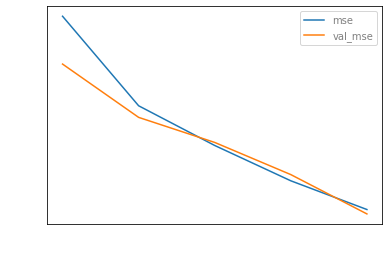

In [341]:
rmse_2 = plot_history(model_2, history_2, X_test, y_test)

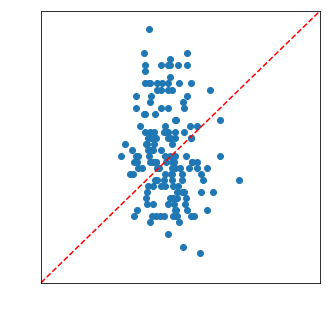

In [342]:
plot_scatter(model_2, X_test)

Our second model after reducing pixels actually outperforms our baseline model with the larger dimensions, with a significantly faster computiation time. This will allow us to increase epochs and add layers. 

### Model #3: added pooling layers, another conv2D layer, and increase in epochs now that computational time has drastically improved

In [261]:
# good to use a repeating structure for cnns

In [345]:
# build the model_3
model_3 = Sequential()
model_3.add(layers.Conv2D(64, kernel_size =(3, 3), input_shape = X_train[0].shape))
model_3.add(layers.MaxPooling2D(pool_size =(2, 2)))
model_3.add(layers.Conv2D(64, (3, 3)))
model_3.add(layers.MaxPooling2D(pool_size =(2, 2)))
model_3.add(Flatten())
model_3.add(layers.Dense(1, activation='linear'))
   
    
# training the model_3
model_3.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
  
# fitting the model_3
history_3 = model_3.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test))

Epoch 1/40
16/16 [==============================] - 2s 109ms/step - loss: 523.3017 - mse: 523.3017 - val_loss: 362.2466 - val_mse: 362.2466
Epoch 2/40
16/16 [==============================] - 2s 101ms/step - loss: 251.1328 - mse: 251.1328 - val_loss: 249.1036 - val_mse: 249.1036
Epoch 3/40
16/16 [==============================] - 2s 112ms/step - loss: 208.7848 - mse: 208.7848 - val_loss: 217.8082 - val_mse: 217.8082
Epoch 4/40
16/16 [==============================] - 2s 108ms/step - loss: 178.4213 - mse: 178.4213 - val_loss: 176.3785 - val_mse: 176.3785
Epoch 5/40
16/16 [==============================] - 2s 117ms/step - loss: 139.9197 - mse: 139.9197 - val_loss: 126.0205 - val_mse: 126.0205
Epoch 6/40
16/16 [==============================] - 2s 116ms/step - loss: 118.6559 - mse: 118.6559 - val_loss: 125.4246 - val_mse: 125.4246
Epoch 7/40
16/16 [==============================] - 2s 104ms/step - loss: 110.7459 - mse: 110.7459 - val_loss: 128.2345 - val_mse: 128.2345
Epoch 8/40
16/16 [==

6/6 [==============================] - 0s 33ms/step - loss: 106.2342 - mse: 106.2342
Root Mean Squared Error: 10.3


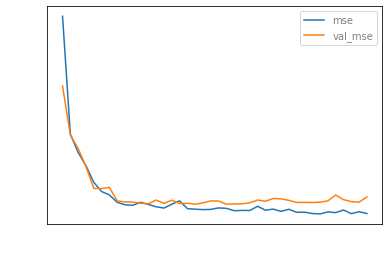

In [348]:
rmse_3 = plot_history(model_3, history_3, X_test, y_test)

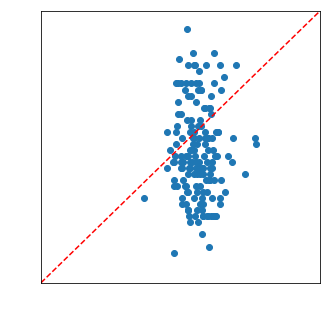

In [349]:
plot_scatter(model_3, X_test)

The third model iteration outperforms the second with an rmse of 10.3, but based on the scatter plot of true vs. predicted values our model is not very accurate. tuning hyperparameters may lead to a l

## Model 4. tuning parameters

In [357]:
model_4 = Sequential()
model_4.add(layers.Conv2D(64, kernel_size=(3,3), input_shape = X_train[0].shape))
model_4.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(Flatten())
model_4.add(layers.Dense(1, activation='linear'))

model_4.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# fitting the model
history_4 = model_4.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test))

Epoch 1/15
16/16 [==============================] - 2s 132ms/step - loss: 629.2829 - mse: 629.2829 - val_loss: 220.0329 - val_mse: 220.0329
Epoch 2/15
16/16 [==============================] - 2s 124ms/step - loss: 258.4335 - mse: 258.4335 - val_loss: 207.5279 - val_mse: 207.5279
Epoch 3/15
16/16 [==============================] - 2s 138ms/step - loss: 186.7776 - mse: 186.7776 - val_loss: 194.4538 - val_mse: 194.4538
Epoch 4/15
16/16 [==============================] - 2s 139ms/step - loss: 166.0966 - mse: 166.0966 - val_loss: 173.7812 - val_mse: 173.7812
Epoch 5/15
16/16 [==============================] - 2s 134ms/step - loss: 143.7134 - mse: 143.7134 - val_loss: 143.0879 - val_mse: 143.0879
Epoch 6/15
16/16 [==============================] - 2s 131ms/step - loss: 120.4232 - mse: 120.4232 - val_loss: 133.2235 - val_mse: 133.2235
Epoch 7/15
16/16 [==============================] - 2s 129ms/step - loss: 98.3684 - mse: 98.3684 - val_loss: 105.0339 - val_mse: 105.0339
Epoch 8/15
16/16 [====

6/6 [==============================] - 0s 23ms/step - loss: 93.0653 - mse: 93.0653
Root Mean Squared Error: 9.6


93.0653076171875

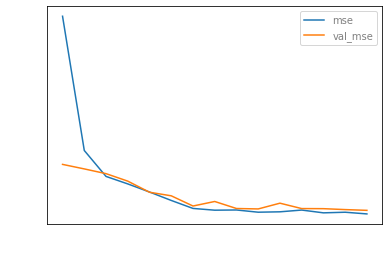

In [358]:
plot_history(model_4, history_4, X_test, y_test)

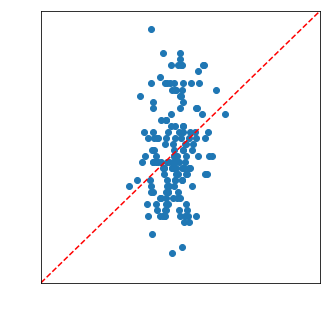

In [359]:
plot_scatter(model_4, X_test)

In [360]:
# with an rmse of 9.4, this is our best model so far. however the scatterplot again does not show any predicting power. lets create a funcition to tune more efficiently 

In [ ]:
## adding cnn layers - show how that doesn't work. 

# Models 5,6,7-- tuning using build_cnn function

To determine the best hyperparameters I am building a function to more efficiently modify 

In [365]:
# build the model
def build_cnn(X_train, y_train, X_test, y_test, neurons, kernel_size, activation, epochs, pool_size, padding):
    
    model = Sequential()
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation= activation))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation = activation, padding=padding))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation = activation, padding=padding))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation = activation, padding=padding))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation = activation, padding=padding))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(layers.Dense(1, activation=activation))

        # training the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    # fitting the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

    return model, history

In [366]:
build_cnn(X_train, y_train, X_test, y_test, 64, (1,1), 'relu', 15, (2,2), 'same')

# kernel size - tuple, must be odd integer, determines the size of the kernel. 
# padding - padding: "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. 
        # When padding="same" and strides=1, the output has the same size as the input.
# strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. 
#         Can be a single integer to specify the same value for all spatial dimensions.


Epoch 1/15
16/16 [==============================] - 1s 86ms/step - loss: 1135.2715 - mse: 1135.2715 - val_loss: 1052.6360 - val_mse: 1052.6360
Epoch 2/15
16/16 [==============================] - 1s 80ms/step - loss: 956.2911 - mse: 956.2911 - val_loss: 677.3602 - val_mse: 677.3602
Epoch 3/15
16/16 [==============================] - 1s 74ms/step - loss: 334.9104 - mse: 334.9104 - val_loss: 175.0781 - val_mse: 175.0781
Epoch 4/15
16/16 [==============================] - 1s 85ms/step - loss: 139.1699 - mse: 139.1699 - val_loss: 121.8528 - val_mse: 121.8528
Epoch 5/15
16/16 [==============================] - 1s 77ms/step - loss: 102.2746 - mse: 102.2746 - val_loss: 116.1324 - val_mse: 116.1324
Epoch 6/15
16/16 [==============================] - 1s 83ms/step - loss: 98.1519 - mse: 98.1519 - val_loss: 109.6740 - val_mse: 109.6740
Epoch 7/15
16/16 [==============================] - 1s 72ms/step - loss: 95.5844 - mse: 95.5844 - val_loss: 110.7684 - val_mse: 110.7684
Epoch 8/15
16/16 [=========

(<tensorflow.python.keras.engine.sequential.Sequential at 0x16cee25b0>,
 <tensorflow.python.keras.callbacks.History at 0x16cf0a250>)

In [328]:
build_cnn(X_train, y_train, X_test, y_test, 32, (1,1), 'relu', 15, (2,2))

Epoch 1/15
16/16 [==============================] - 1s 42ms/step - loss: 1100.0951 - mse: 1100.0951 - val_loss: 970.8015 - val_mse: 970.8015
Epoch 2/15
16/16 [==============================] - 1s 32ms/step - loss: 823.8523 - mse: 823.8523 - val_loss: 519.1631 - val_mse: 519.1631
Epoch 3/15
16/16 [==============================] - 1s 32ms/step - loss: 278.2404 - mse: 278.2404 - val_loss: 157.5882 - val_mse: 157.5882
Epoch 4/15
16/16 [==============================] - 1s 32ms/step - loss: 150.8130 - mse: 150.8130 - val_loss: 134.1697 - val_mse: 134.1697
Epoch 5/15
16/16 [==============================] - 1s 33ms/step - loss: 125.9268 - mse: 125.9268 - val_loss: 126.2531 - val_mse: 126.2531
Epoch 6/15
16/16 [==============================] - 1s 31ms/step - loss: 117.2001 - mse: 117.2001 - val_loss: 118.6308 - val_mse: 118.6308
Epoch 7/15
16/16 [==============================] - 1s 33ms/step - loss: 107.1141 - mse: 107.1141 - val_loss: 110.1006 - val_mse: 110.1006
Epoch 8/15
16/16 [=======

(<tensorflow.python.keras.engine.sequential.Sequential at 0x15e5ae4c0>,
 <tensorflow.python.keras.callbacks.History at 0x15e605850>)

In [273]:
# - mention there seems to be no instance of overfitting so we should continue to add layers/ increase epochs / make more complex 

#  -------------------------------------- FINAL MODEL EVALUATION ----------------------------------------------------

# -------------------------------------- CONCLUSION AND NEXT STEPS ----------------------------------------------

- with more time, I would look into creating my own architecture to mix categorical variables with image classification. this would help me take genre of a playlist into account, as my hypothesis is that album art could affect success of a track depending on the genre it's in. 

- I would also look into finding a different target variable to measure "success". 